In [ ]:
%pip install neo4j py2neo pandas networkx matplotlib pyvis

In [ ]:
from neo4j import GraphDatabase
import pandas as pd

# Neo4j connection details
uri = "bolt://192.168.86.28:7687"
username = "neo4j"
password = "testpassword"

In [ ]:
# Connect to Neo4j
driver = GraphDatabase.driver(uri, auth=(username, password))

In [ ]:
# Define the UAS ontology with several UAS types
uas_ontology = [
    {"entity": "UAS", "attributes": {"name": "MQ-9 Reaper", "type": "Fixed-wing", "manufacturer": "General Atomics", "max_sensors": 4, "max_weapons": 4, "last_check": "2024-01-15"}},
    {"entity": "UAS", "attributes": {"name": "RQ-4 Global Hawk", "type": "Fixed-wing", "manufacturer": "Northrop Grumman", "max_sensors": 6, "max_weapons": 0}},
    {"entity": "UAS", "attributes": {"name": "MQ-1 Predator", "type": "Fixed-wing", "manufacturer": "General Atomics", "max_sensors": 3, "max_weapons": 2}},
    {"entity": "Sensor", "attributes": {"type": "EO/IR", "model": "AN/DAS-1", "manufacturer": "Raytheon"}},
    {"entity": "Sensor", "attributes": {"type": "Radar", "model": "AN/APY-8", "manufacturer": "Raytheon"}},
    {"entity": "Sensor", "attributes": {"type": "SIGINT", "model": "AN/ALR-69", "manufacturer": "BAE Systems"}},
    {"entity": "Payload", "attributes": {"type": "Munition", "model": "AGM-114 Hellfire", "weight": "49kg"}},
    {"entity": "Payload", "attributes": {"type": "Munition", "model": "GBU-12 Paveway II", "weight": "230kg"}},
    {"entity": "Payload", "attributes": {"type": "Munition", "model": "GBU-38 JDAM", "weight": "227kg"}},
    {"entity": "Mission", "attributes": {"name": "ISR", "duration": "30 hours"}},
    {"entity": "Mission", "attributes": {"name": "Close Air Support", "duration": "12 hours"}},
    {"entity": "Operator", "attributes": {"name": "John Doe", "rank": "Captain", "certification": "Level 1"}},
    {"entity": "GroundStation", "attributes": {"name": "GCS-3000", "location": "Nevada"}},
    {"entity": "Command", "attributes": {"name": "USAF", "base": "Creech AFB"}},
    {"entity": "Maintenance", "attributes": {"type": "Routine Check", "interval": "100 flight hours"}},
]

In [ ]:
# Define relationships with allowable quantities
uas_relationships = [
    {"start_node": "UAS", "relationship": "HAS_SENSOR", "end_node": "Sensor", "attributes": {"max_quantity": 4, "applicable_to": "MQ-9 Reaper"}},
    {"start_node": "UAS", "relationship": "HAS_SENSOR", "end_node": "Sensor", "attributes": {"max_quantity": 6, "applicable_to": "RQ-4 Global Hawk"}},
    {"start_node": "UAS", "relationship": "HAS_SENSOR", "end_node": "Sensor", "attributes": {"max_quantity": 3, "applicable_to": "MQ-1 Predator"}},
    {"start_node": "UAS", "relationship": "CARRIES_PAYLOAD", "end_node": "Payload", "attributes": {"max_quantity": 4, "applicable_to": "MQ-9 Reaper"}},
    {"start_node": "UAS", "relationship": "CARRIES_PAYLOAD", "end_node": "Payload", "attributes": {"max_quantity": 2, "applicable_to": "MQ-1 Predator"}},
    {"start_node": "UAS", "relationship": "CARRIES_PAYLOAD", "end_node": "Payload", "attributes": {"max_quantity": 0, "applicable_to": "RQ-4 Global Hawk"}},
    {"start_node": "UAS", "relationship": "PERFORMS_MISSION", "end_node": "Mission", "attributes": {"frequency": "Weekly"}},
    {"start_node": "Operator", "relationship": "OPERATES", "end_node": "UAS", "attributes": {"since": "2022"}},
    {"start_node": "GroundStation", "relationship": "CONTROLS", "end_node": "UAS", "attributes": {"frequency": "Continuous"}},
    {"start_node": "Command", "relationship": "DEPLOYS", "end_node": "UAS", "attributes": {"deployment": "Global"}},
    {"start_node": "Maintenance", "relationship": "APPLIES_TO", "end_node": "UAS", "attributes": {"last_check": "2024-01-15"}}
]

In [ ]:
# Function to create nodes
def create_nodes(tx, nodes):
    for node in nodes:
        entity = node["entity"]
        attributes = node["attributes"]
        attrs = ", ".join([f"{k}: '{v}'" for k, v in attributes.items()])
        query = f"CREATE (n:{entity} {{{attrs}}})"
        tx.run(query)

# Function to create relationships
def create_relationships(tx, relationships):
    for rel in relationships:
        start_node = rel["start_node"]
        relationship = rel["relationship"]
        end_node = rel["end_node"]
        attributes = rel["attributes"]
        attrs = ", ".join([f"{k}: '{v}'" for k, v in attributes.items()])
        query = (
            f"MATCH (a:{start_node}), (b:{end_node}) "
            f"CREATE (a)-[r:{relationship} {{{attrs}}}]->(b)"
        )
        tx.run(query)

In [ ]:
# Populate the Neo4j database
with driver.session() as session:
    session.write_transaction(create_nodes, uas_ontology)
    session.write_transaction(create_relationships, uas_relationships)

In [ ]:
# Function to run a Cypher query and return the results as a DataFrame
def run_query(query):
    with driver.session() as session:
        result = session.run(query)
        return pd.DataFrame([dict(record) for record in result])

# Example usage
query = "MATCH (n) RETURN n LIMIT 10"
df = run_query(query)
df.head()

In [ ]:
# List All UAS Types:
query = """
MATCH (u:UAS)
RETURN u.name AS UAS_Name, u.type AS UAS_Type, u.manufacturer AS Manufacturer
"""
df = run_query(query)
print(df)

In [ ]:
# List Sensors and Their Manufacturers:
query = """
MATCH (s:Sensor)
RETURN s.type AS Sensor_Type, s.model AS Model, s.manufacturer AS Manufacturer
"""
df = run_query(query)
print(df)

In [ ]:
# List Payloads and Their Weights:
query = """
MATCH (p:Payload)
RETURN p.type AS Payload_Type, p.model AS Model, p.weight AS Weight
"""
df = run_query(query)
print(df)

In [ ]:
# Find UAS Types and Their Allowable Sensors:
query = """
MATCH (u:UAS)-[r:HAS_SENSOR]->(s:Sensor)
RETURN u.name AS UAS_Name, s.type AS Sensor_Type, r.max_quantity AS Max_Quantity
"""
df = run_query(query)
print(df)

In [ ]:
# Find UAS Types and Their Allowable Payloads:
query = """
MATCH (u:UAS)-[r:CARRIES_PAYLOAD]->(p:Payload)
RETURN u.name AS UAS_Name, p.type AS Payload_Type, p.model AS Model, r.max_quantity AS Max_Quantity
"""
df = run_query(query)
print(df)

In [ ]:
# Find All Missions Performed by Each UAS Type:
query = """
MATCH (u:UAS)-[:PERFORMS_MISSION]->(m:Mission)
RETURN u.name AS UAS_Name, m.name AS Mission_Name, m.duration AS Duration
"""
df = run_query(query)
print(df)

In [ ]:
# List Operators and Their UAS Types:
query = """
MATCH (o:Operator)-[:OPERATES]->(u:UAS)
RETURN o.name AS Operator_Name, o.rank AS Rank, u.name AS UAS_Name, o.certification AS Certification
"""
df = run_query(query)
print(df)

In [ ]:
# Find UAS Controlled by Ground Stations:
query = """
MATCH (g:GroundStation)-[:CONTROLS]->(u:UAS)
RETURN g.name AS GroundStation_Name, g.location AS Location, u.name AS UAS_Name
"""
df = run_query(query)
print(df)

In [ ]:
# List UAS Deployment Details by Command:
query = """
MATCH (c:Command)-[:DEPLOYS]->(u:UAS)
RETURN c.name AS Command_Name, c.base AS Base, u.name AS UAS_Name, u.type AS UAS_Type
"""
df = run_query(query)
print(df)

In [ ]:
# List Maintenance Details for Each UAS:
query = """
MATCH (m:Maintenance)-[:APPLIES_TO]->(u:UAS)
RETURN u.name AS UAS_Name, m.type AS Maintenance_Type, m.interval AS Interval, m.last_check AS Last_Check
"""
df = run_query(query)
print(df)

In [ ]:
# Close the driver connection
driver.close()

In [ ]:
# Query to clear the database
#clear_db_query = "MATCH (n) DETACH DELETE n"

In [100]:
from py2neo import Graph
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import os

# lets build some plots
# Connect to Neo4j
graph = Graph(uri, auth=(username, password))

# Query to get nodes and relationships
nodes_query = """
MATCH (n)
RETURN id(n) AS id, labels(n) AS labels, n.name AS name
"""
relationships_query = """
MATCH (n)-[r]->(m)
RETURN id(n) AS source, type(r) AS relationship, id(m) AS target
"""

# Run the queries
nodes = graph.run(nodes_query).data()
relationships = graph.run(relationships_query).data()

# Convert results to DataFrame
nodes_df = pd.DataFrame(nodes)
relationships_df = pd.DataFrame(relationships)

In [102]:
# Create a directed graph
G = nx.DiGraph()

# Add nodes
for index, row in nodes_df.iterrows():
    G.add_node(row['id'], label=row['labels'][0], name=row['name'])

# Add edges
for index, row in relationships_df.iterrows():
    G.add_edge(row['source'], row['target'], relationship=row['relationship'])


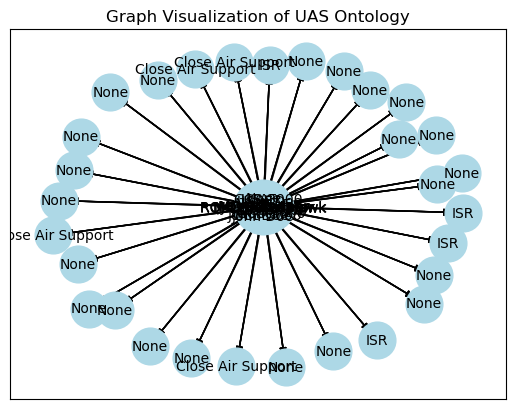

In [104]:
# Define a function to plot the graph
def plot_graph(G):
    pos = nx.spring_layout(G)  # positions for all nodes
    labels = nx.get_node_attributes(G, 'name')
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, edge_color='black')
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, labels, font_size=10)
    
    plt.title('Graph Visualization of UAS Ontology')
    plt.show()

# Plot the graph
plot_graph(G)


In [129]:
from py2neo import Graph
import pandas as pd
from pyvis.network import Network

# Connect to Neo4j
graph = Graph(uri, auth=(username, password))

# Query to get a small subset of nodes and relationships
nodes_query = """
MATCH (n)
RETURN id(n) AS id, labels(n) AS labels, n.name AS name
LIMIT 10
"""
relationships_query = """
MATCH (n)-[r]->(m)
WHERE id(n) IN [SELECTED_IDS] AND id(m) IN [SELECTED_IDS]
RETURN id(n) AS source, type(r) AS relationship, id(m) AS target
LIMIT 10
"""

# Run the queries
nodes = graph.run(nodes_query).data()
selected_ids = [node['id'] for node in nodes]  # Extract node IDs

# Replace placeholder with actual IDs
relationships_query = relationships_query.replace("[SELECTED_IDS]", str(selected_ids))

relationships = graph.run(relationships_query).data()

# Convert results to DataFrame
nodes_df = pd.DataFrame(nodes)
relationships_df = pd.DataFrame(relationships)

In [131]:
from pyvis.network import Network

# Create a pyvis Network object
net = Network(notebook=True, height='750px', width='100%', bgcolor='#222222', font_color='white', cdn_resources='in_line')

# Add nodes to the network
for index, row in nodes_df.iterrows():
    net.add_node(row['id'], label=row['name'], title=row['labels'][0])

# Add edges to the network
for index, row in relationships_df.iterrows():
    if row['source'] in net.get_nodes() and row['target'] in net.get_nodes():
        net.add_edge(row['source'], row['target'], title=row['relationship'])

In [133]:
import os

# Generate the HTML content
html_content = net.generate_html()

# Get the current working directory
current_directory = os.getcwd()
file_path = os.path.join(current_directory, "simple_uas_ontology.html")

# Write the HTML content to a file with utf-8 encoding
with open(file_path, "w", encoding="utf-8") as file:
    file.write(html_content)


In [135]:
from IPython.display import IFrame

# Display the graph inline in Jupyter Notebook
IFrame(src=file_path, width=800, height=600)
